In [33]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
import warnings
warnings.filterwarnings("ignore")

In [34]:
# Step 2: Load Data (use path where files are unzipped locally)
data_path = "store_forecasting_data"  # replace with your folder name if different
train = pd.read_csv(os.path.join(data_path, "train.csv"), nrows=100000)  # sample for memory efficiency
stores = pd.read_csv(os.path.join(data_path, "stores.csv"))
oil = pd.read_csv(os.path.join(data_path, "oil.csv"))
holidays = pd.read_csv(os.path.join(data_path, "holidays_events.csv"))

In [35]:
# Step 3: Preprocess and Merge
train['date'] = pd.to_datetime(train['date'])
oil['date'] = pd.to_datetime(oil['date'])
holidays['date'] = pd.to_datetime(holidays['date'])
oil['dcoilwtico'] = oil['dcoilwtico'].interpolate()

train = train.merge(stores, on='store_nbr', how='left')
train = train.merge(oil, on='date', how='left')

holidays = holidays[holidays['locale'] == 'National'][['date', 'type']]
holidays['is_holiday'] = 1
train = train.merge(holidays, on='date', how='left')
train['is_holiday'] = train['is_holiday'].fillna(0)
train['earthquake'] = (train['date'] == pd.Timestamp('2016-04-16')).astype(int)
train['payday'] = train['date'].dt.day.isin([15, 31]).astype(int)

In [36]:
# Step 4: Feature Engineering
train['day'] = train['date'].dt.day
train['week'] = train['date'].dt.isocalendar().week.astype(int)
train['month'] = train['date'].dt.month
train['year'] = train['date'].dt.year
train['day_of_week'] = train['date'].dt.dayofweek

# One-hot encoding
if 'type' in train.columns:
    train = pd.get_dummies(train, columns=['type'], drop_first=True)
if 'cluster' in train.columns:
    train = pd.get_dummies(train, columns=['cluster'], drop_first=True)

In [37]:
# Step 5: Create Lag Features
train = train.sort_values(by=['store_nbr', 'family', 'date'])
train['lag_1'] = train.groupby(['store_nbr', 'family'])['sales'].shift(1)
train['lag_7'] = train.groupby(['store_nbr', 'family'])['sales'].shift(7)
train = train.dropna()

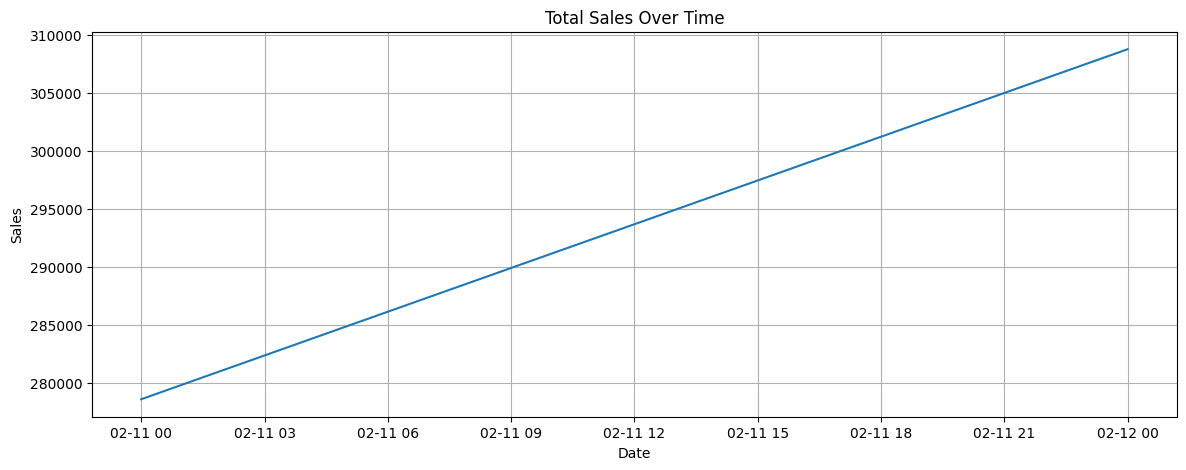

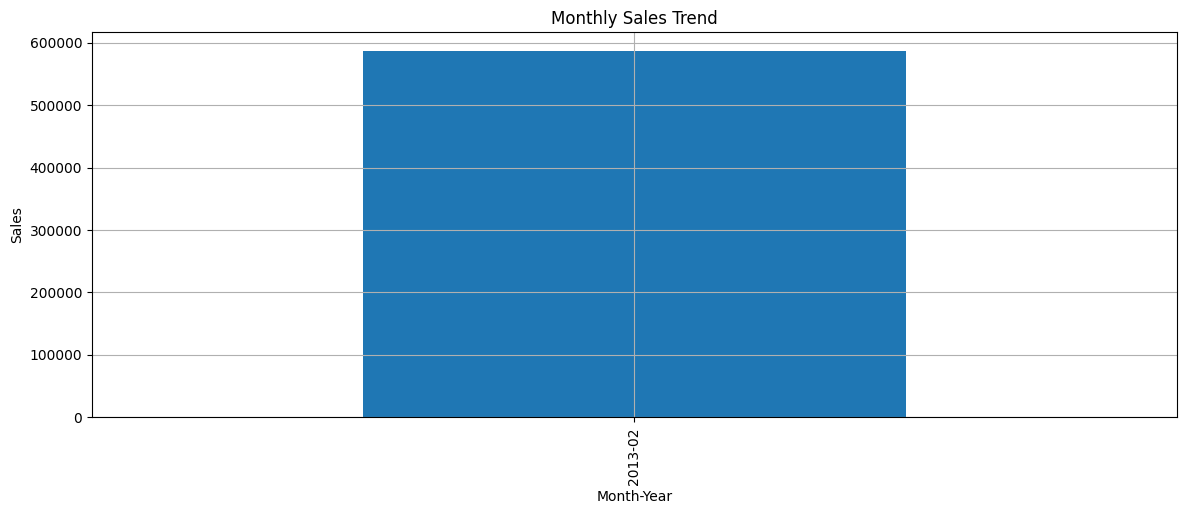

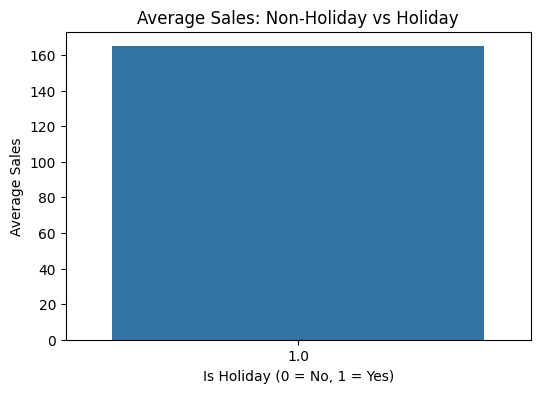

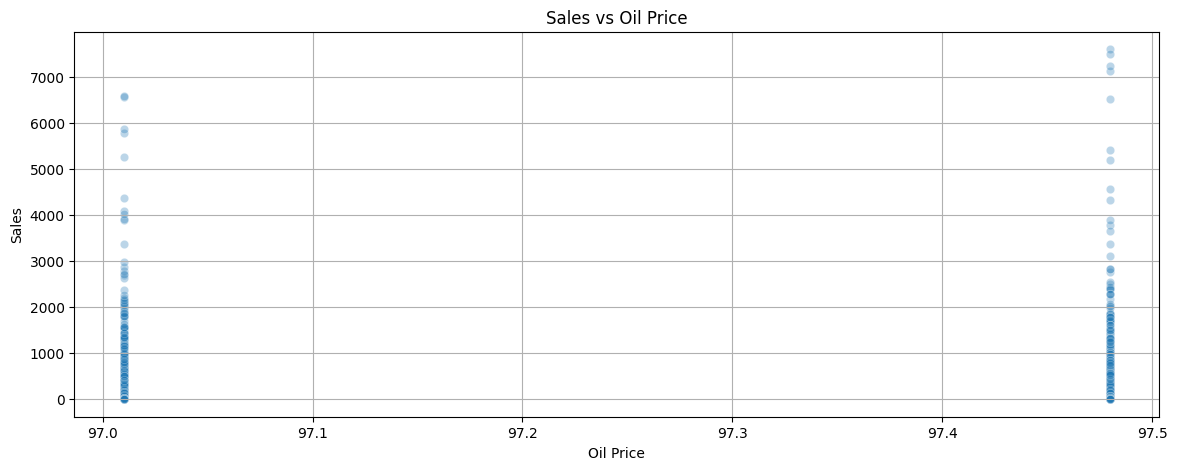

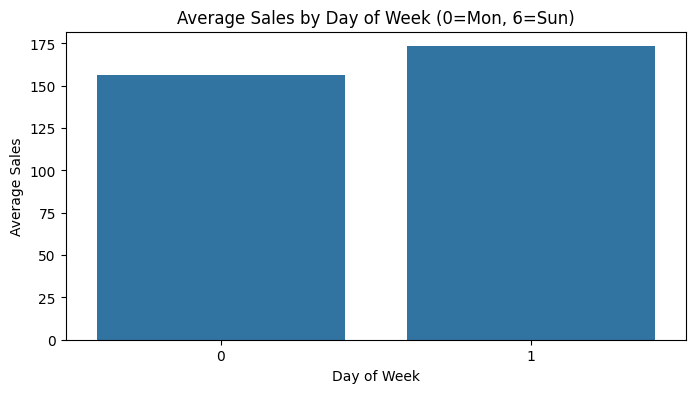

In [38]:
# Step 5: Exploratory Data Analysis (EDA)
# 1. Sales Over Time
sales_over_time = train.groupby('date')['sales'].sum().reset_index()
plt.figure(figsize=(14, 5))
sns.lineplot(data=sales_over_time, x='date', y='sales')
plt.title("Total Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid(True)
plt.show()
# 2. Monthly Sales Trends
train['month_year'] = train['date'].dt.to_period('M')
monthly_sales = train.groupby('month_year')['sales'].sum()
monthly_sales.plot(kind='bar', figsize=(14, 5))
plt.title("Monthly Sales Trend")
plt.xlabel("Month-Year")
plt.ylabel("Sales")
plt.grid(True)
plt.xticks(rotation=90)
plt.show()
# 3. Sales Before and After Holidays
holiday_sales = train.groupby(['is_holiday'])['sales'].mean()
plt.figure(figsize=(6, 4))
sns.barplot(x=holiday_sales.index, y=holiday_sales.values)
plt.title("Average Sales: Non-Holiday vs Holiday")
plt.xlabel("Is Holiday (0 = No, 1 = Yes)")
plt.ylabel("Average Sales")
plt.show()
# 4. Correlation with Oil Prices
plt.figure(figsize=(14, 5))
sns.scatterplot(x=train['dcoilwtico'], y=train['sales'], alpha=0.3)
plt.title("Sales vs Oil Price")
plt.xlabel("Oil Price")
plt.ylabel("Sales")
plt.grid(True)
plt.show()
# 5. Weekly Sales Pattern
weekly_sales = train.groupby('day_of_week')['sales'].mean()
plt.figure(figsize=(8, 4))
sns.barplot(x=weekly_sales.index, y=weekly_sales.values)
plt.title("Average Sales by Day of Week (0=Mon, 6=Sun)")
plt.xlabel("Day of Week")
plt.ylabel("Average Sales")
plt.show()

In [39]:
# Step 6: Prepare Feature Set
non_numeric_cols = ['id', 'date', 'family']
features = [col for col in train.columns if col not in non_numeric_cols + ['sales']]
X = train[features].select_dtypes(include=[np.number])
y = train['sales']

In [48]:
# Step 7: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [41]:
# Step 8: Train Models
rf = RandomForestRegressor(n_estimators=100, random_state=42)
xgb = XGBRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [42]:
# Step 9: Predictions
rf_preds = rf.predict(X_test)
xgb_preds = xgb.predict(X_test)
naive_preds = X_test['lag_1']

In [43]:
# --- ARIMA Model ---
arima_series = pd.Series(y_train.values, index=pd.date_range(start=0, periods=len(y_train), freq='D'))
arima_model = ARIMA(arima_series, order=(5,1,0))
arima_result = arima_model.fit()
arima_preds = arima_result.forecast(steps=len(y_test)).values

In [44]:
# --- LSTM Model ---
# Scale the data
scaler = MinMaxScaler()
y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1,1))
y_test_scaled = scaler.transform(y_test.values.reshape(-1,1))

In [45]:
# Sequence generator
def create_sequences(data, seq_length=10):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])
        y.append(data[i])
    return np.array(X), np.array(y)

seq_length = 10
X_lstm_train, y_lstm_train = create_sequences(y_train_scaled, seq_length)
X_lstm_valid, y_lstm_valid = create_sequences(y_valid_scaled, seq_length)

X_lstm_train = X_lstm_train.reshape((X_lstm_train.shape[0], X_lstm_train.shape[1], 1))
X_lstm_valid = X_lstm_valid.reshape((X_lstm_valid.shape[0], X_lstm_valid.shape[1], 1))

lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(seq_length, 1)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_lstm_train, y_lstm_train, epochs=5, verbose=0)

lstm_preds_scaled = lstm_model.predict(X_lstm_valid)
lstm_preds = scaler.inverse_transform(lstm_preds_scaled).flatten()
y_lstm_valid_orig = scaler.inverse_transform(y_lstm_valid.reshape(-1,1)).flatten()

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [46]:
# --- Evaluate Models ---
def evaluate(y_true, y_pred):
    return {
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAPE': mean_absolute_percentage_error(y_true, y_pred),
        'R2': r2_score(y_true, y_pred)
    }

metrics = {
    'Naive Forecast': evaluate(y_test, naive_preds),
    'ARIMA': evaluate(y_test.values, arima_preds),
    'LSTM': evaluate(y_lstm_valid_orig, lstm_preds),
    'Random Forest': evaluate(y_test, rf_preds),
    'XGBoost': evaluate(y_test, xgb_preds)
}
metrics_df = pd.DataFrame(metrics).T
print(metrics_df)


                      RMSE          MAPE        R2
Naive Forecast  167.398729  1.231700e+15  0.967886
ARIMA           947.399646  1.101126e+18 -0.028639
LSTM            872.188436  3.371603e+17  0.124987
Random Forest   355.485880  9.247373e+14  0.855176
XGBoost         395.385042  1.489550e+15  0.820842


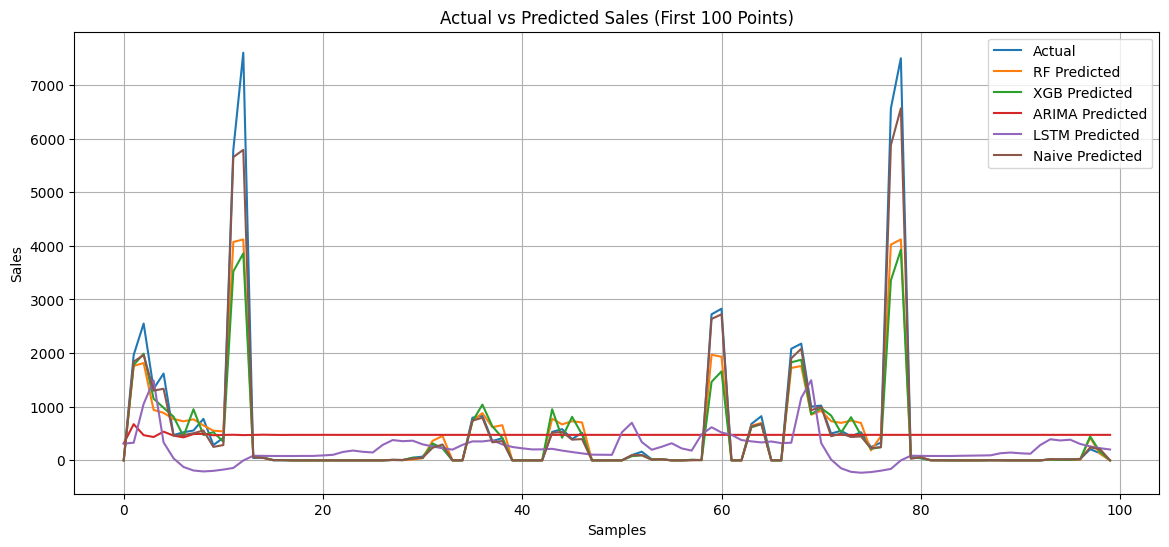

In [47]:
# --- Plot Actual vs Predicted ---
plt.figure(figsize=(14, 6))
plt.plot(y_test.values[:100], label='Actual')
plt.plot(rf_preds[:100], label='RF Predicted')
plt.plot(xgb_preds[:100], label='XGB Predicted')
plt.plot(arima_preds[:100], label='ARIMA Predicted')
plt.plot(lstm_preds[:100], label='LSTM Predicted')
plt.plot(naive_preds.values[:100], label='Naive Predicted')
plt.legend()
plt.title("Actual vs Predicted Sales (First 100 Points)")
plt.xlabel("Samples")
plt.ylabel("Sales")
plt.grid(True)
plt.show()